In [1]:
# A single-file scripts for running the ellipse experiment, 
# all confounders were included in Eq. 4 during model training.
import pandas as pd
import numpy as np
import cv2 as cv
import glob
import os
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models
from PIL import Image, ImageOps
import cv2
import imgaug as ia
from imgaug import augmenters as iaa
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader,TensorDataset
import sys
import torch.optim as optim
import math
sys.path.append(".")
from sklearn.feature_selection import mutual_info_regression
import dcor



In [2]:
# define the autoencoder model------------------------------------


class Encoder(nn.Module):
    def __init__(self, nc, nef, nz, isize, device):
        super(Encoder, self).__init__()

        # Device
        self.device = device

        # Encoder: (nc, isize, isize) -> (nef*8, isize//16, isize//16)
        self.encoder = nn.Sequential(
            nn.Conv2d(nc, nef, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef),

            nn.Conv2d(nef, nef*2, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef*2),

            nn.Conv2d(nef*2, nef*4, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef*4),

            nn.Conv2d(nef*4, nef*8, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef*8)
        )

        # Map the encoded feature map to the latent vector of mean, (log)variance
        out_size = isize // 16
        self.mean = nn.Linear(nef*8*out_size*out_size, nz)
        self.logvar = nn.Linear(nef*8*out_size*out_size, nz)

    def reparametrize(self, mean, logvar):
        std = logvar.mul(0.5).exp_()
        multi_norm = torch.FloatTensor(std.size()).normal_().to(self.device)
        multi_norm = Variable(multi_norm)
        return multi_norm.mul(std).add_(mean)

    def forward(self, inputs):
        # Batch size
        batch_size = inputs.size(0)
        # Encoded feature map
        hidden = self.encoder(inputs)
        # Reshape
        hidden = hidden.view(batch_size, -1)
        # Calculate mean and (log)variance
        mean, logvar = self.mean(hidden), self.logvar(hidden)
        # Sample
        latent_z = self.reparametrize(mean, logvar)
        #latent_z = mean
        return latent_z, mean, logvar

class Decoder(nn.Module):
    def __init__(self, nc, ndf, nz, isize):
        super(Decoder, self).__init__()

        # Map the latent vector to the feature map space
        self.ndf = ndf
        self.out_size = isize // 16
        self.decoder_dense = nn.Sequential(
            nn.Linear(nz, ndf*8*self.out_size*self.out_size),
            nn.ReLU(True)
        )
        # Decoder: (ndf*8, isize//16, isize//16) -> (nc, isize, isize)
        self.decoder_conv = nn.Sequential(
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf*8, ndf*4, 3, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ndf*4, 1.e-3),

            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf*4, ndf*2, 3, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ndf*2, 1.e-3),
        
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf*2, ndf, 3, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ndf, 1.e-3),

            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf, nc, 3, padding=1),
            nn.ReLU(True)
        )

    def forward(self, input):
        batch_size = input.size(0)
        hidden = self.decoder_dense(input).view(
            batch_size, self.ndf*8, self.out_size, self.out_size)
        output = self.decoder_conv(hidden)
        return output

class VAE(nn.Module):
    def __init__(self, nc=1, ndf=4, nef=4, nz=8, isize=64, device=torch.device("cuda:0"), is_train=True):
        super(VAE, self).__init__()

        self.nz = nz
        # Encoder
        self.encoder = Encoder(nc=nc, nef=nef, nz=nz, isize=isize, device=device)
        # Decoder
        self.decoder = Decoder(nc=nc, ndf=ndf, nz=nz, isize=isize)
        self.pe = nn.Linear(nz, 1, bias=False)
        if is_train == False:
            for param in self.encoder.parameters():
                param.requires_grad = False
            for param in self.decoder.parameters():
                param.requires_grad = False

    def forward(self, x):
        latent_z, mean, logvar = self.encoder(x)
        rec_x = self.decoder(latent_z)
        zp = self.pe(latent_z)

        return rec_x, mean, logvar, latent_z, zp, 
    
    def encode(self, x):
        latent_z, _, _ = self.encoder(x)
        return latent_z

    def decode(self, z):
        return self.decoder(z)

In [3]:
#loss functions---------------------------------

def torch_corr(input1, input2, device):  #The correlation loss function

    mean_1 = torch.mean(input1)
    mean_2 = torch.mean(input2)
    var_1 = torch.var(input1)
    var_2 = torch.var(input2)
    vector_mean1 = mean_1*torch.ones([len(input1)]).to(device)
    vector_mean2 = mean_2*torch.ones([len(input2)]).to(device)
    #print(input2, vector_mean2)
    diff_1 = input1 - vector_mean1
    diff_2 = input2 - vector_mean2

    exp = torch.mul(diff_1,diff_2)
    exp = torch.sum(exp)   


    exp = exp / len(input1)
    exp = exp / torch.sqrt(var_1*var_2)
    return abs(exp)


class KLDLoss(nn.Module):
    def __init__(self, reduction='sum'):
        super(KLDLoss, self).__init__()
        self.reduction = reduction

    def forward(self, mean, logvar):
        # KLD loss
        kld_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp(), 1)
        # Size average
        if self.reduction == 'mean':
            kld_loss = torch.mean(kld_loss)
        elif self.reduction == 'sum':
            kld_loss = torch.sum(kld_loss)
        return kld_loss
    


In [4]:
# data loader----------------------------------


class ImgAugTransform:
  def __init__(self):
    self.aug = iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Sometimes(0.4,\
            iaa.ContrastNormalization((0.8, 1.2), per_channel=0.5)),
        iaa.Sometimes(0.4,\
            iaa.GaussianBlur(sigma=(0, 0.2))),
    ])
      
  def __call__(self, img):
    img = np.array(img)
    img = self.aug.augment_image(img)
    return img

class ImageDataset(Dataset):
    def __init__(self, paths_image,is_aug=False):
        super(ImageDataset, self).__init__()

        # Length
        self.length = len(paths_image)
        # Image path
        self.paths_image = paths_image

        # Augment
        self.is_aug = is_aug
        self.transform = transforms.Compose([
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            ImgAugTransform(),
            lambda x: Image.fromarray(x),
        ])
        # Preprocess
        self.output = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            ])

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # Image
        img = Image.open(self.paths_image[idx].strip())  # Strip any extra whitespace or newline characters
        img = self.output(img)

        # File name parsing
        file_name = self.paths_image[idx].strip()  # Ensure no whitespace issues
        file_name_no_ext = file_name.split('/')[-1].replace('.png', '')  # Get just the filename without the path or extension

        # Split filename into components
        split_file_name = file_name_no_ext.split('_')
        #print(split_file_name)
        if len(split_file_name) == 5:  # Check for correct format (imageID_area_rotation_position_brightness)
            imageID = split_file_name[0]
            area = float(split_file_name[1])           # Convert area to float
            rotation = float(split_file_name[2])       # Convert rotation to float
            position = float(split_file_name[3])       # Convert position to float
            brightness = float(split_file_name[4])     # Convert brightness to float

            # Normalize brightness if needed
            normalized_brightness = float(brightness/255)
        else:
            raise ValueError("Filename format is incorrect. Ensure it follows '{imageID}_{area}_{rotation}_{position}_{brightness}.png'")

        return img, area, rotation, position, normalized_brightness, imageID
    


# this dataloader was implemented with class 'ImageDataset' for dynamic memory control
def get_celeba_loaders(batch_train, batch_test):
    f_train = open('/ellipse_dataset/folds_split/train_fold_5.txt','r')      # paths for input
    file_list_train = f_train.readlines()

    f_test = open('/ellipse_dataset/folds_split/test_fold_5.txt','r')      # paths for input
    file_list_test = f_test.readlines()

    datasets = {
        "train":  ImageDataset(file_list_train,True),
        "test": ImageDataset(file_list_test, False)
    }

    dataloaders = {
        "train": DataLoader(  datasets["train"],  batch_size=batch_train, shuffle=True),
        "test": DataLoader( datasets["test"], batch_size=batch_test, shuffle=False)
    }
    return dataloaders




In [5]:
# display functions--------------------------


if "DISPLAY" not in os.environ:
    plt.switch_backend("Agg")

def plot_loss(dirname, history):
    """ Plot loss """

    plot_train = np.array(history["train"])
    is_val = ("test" in history.keys())
    if is_val:
        plot_val = np.array(history["test"])

    if not os.path.exists(dirname):
        os.makedirs(dirname)

    # epochs
    n_epochs = len(plot_train)

    # X axis
    x = [i for i in range(1, n_epochs+1)]
    
    # plot loss
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.xlabel('epoch')
    plt.plot(x, plot_train[:], label='train loss')
    if is_val:
        plt.plot(x, plot_val[:], label='test loss')

    plt.legend()
    plt.savefig(os.path.join(dirname,'loss.png'))
    plt.close()

def imsave(x, rec_x, path, row=2, col=2):
    """ Save the first row*col images """
    #print(x.size())
    #exit(0)
    # Save dir
    save_dir = os.path.dirname(path)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # To cpu, numpy, uint8 format and (num, h, w, c) shape
    in_imgs = (x.clone().cpu().detach().numpy()[:row*col]*255)\
        .astype(np.uint8).transpose(0, 2, 3, 1)[:, :, :, ::-1]
    out_imgs = (rec_x.clone().cpu().detach().numpy()[:row*col]*255)\
        .astype(np.uint8).transpose(0, 2, 3, 1)[:, :, :, ::-1]

    # Reshape
    in_imgs = cv2.vconcat([cv2.hconcat([in_imgs[i+j] for j in range(0, col)])
        for i in range(0, row*col, col)])
    out_imgs = cv2.vconcat([cv2.hconcat([out_imgs[i+j] for j in range(0, col)])
        for i in range(0, row*col, col)])
   # print(in_imgs.shape)
    #exit(0)
    # Concat
    h, _,  = in_imgs.shape
    margin_shape = (h, 5 )
    margin = np.ones(margin_shape, np.uint8) * 255
    concat_imgs = cv2.hconcat([in_imgs, margin, out_imgs])

    # Save
    cv2.imwrite(path, concat_imgs)

def imsave_inp(x, path, row=1, col=11):
    """ Save the interpolated images """

    # Save dir
    save_dir = os.path.dirname(path)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # To cpu, numpy, uint8 format and (num, h, w, c) shape
    in_imgs = (x.clone().cpu().detach().numpy()[:row*col]*255)\
        .astype(np.uint8).transpose(0, 2, 3, 1)[:, :, :, ::-1]

    # Reshape
    in_imgs = cv2.vconcat([cv2.hconcat([in_imgs[i+j] for j in range(0, col)])
        for i in range(0, row*col, col)])

    # Save
    cv2.imwrite(path, in_imgs)

class Logger:
    def __init__(self, path):
        self.f = open(path, 'w')

    def __del__(self):
        self.f.close()

    def write(self, text):
        self.f.write(text+"\n")
        self.f.flush()
        print(text)

In [9]:
# training------------------------

# Device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
epochs=300
batch_train = 32
batch_test = 64
eta = 2.0 ## see Eq. 3 in the paper     if eta==0, then disable confounder correction
lambda_par=8000 # see Eq. 5 in the paper
# Dataloader
dataloaders = get_celeba_loaders(batch_train, batch_test) # train batch size : 16;  test batch size: 64
# Model
model = VAE(device=device).to(device)


reconst_criterion = nn.MSELoss(reduction='sum')

kld_criterion = KLDLoss(reduction='sum')

# Solver
optimizer = optim.Adam(model.parameters(), lr=0.005)
# Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.97, last_epoch=-1)

#----model lr, see t^=LR(zp) in the manuscript

model_lr = torch.nn.Linear(1,1).to(device)
optimizer_lr = optim.Adam(model_lr.parameters(), lr=0.05)
scheduler_lr = optim.lr_scheduler.StepLR(optimizer_lr, 1, gamma=0.97, last_epoch=-1)
#----
# Log
logdir = './log/pvae'

if not os.path.exists(logdir):
    os.makedirs(logdir)
# Logger
logger = Logger(os.path.join(logdir, "log.txt"))
# History
history = {"train": [], "test": []}


# Start training
for epoch in range(epochs):
    num_list, pos_list, rot_list, zp_list, bri_list,logit_out_list = [],[],[],[],[],[]
    mse_loss_total = 0
    for phase in ["train", "test"]:
        if phase == "train":
            model.train(True)
            model_lr.train(True)
            logger.write(f"\n----- Epoch {epoch+1} -----")
        else:
            model.train(False)
            model_lr.train(False)
        # Loss
        running_loss = 0.0
        # Data num
        data_num = 0

        i = 0
        i_test = 0
        for data in dataloaders[phase]:
            x = data[0].to(device)
            num_t = data[1].to(device) #area
            rot_t = data[2].to(device) #ratation
            pos_t = data[3].to(device) #position
            bri_t = data[4].to(device) #brightness
            id_name = data[5]
            #print(num_t,col_t,red_t,id_name)
            #print(num_t, col_t,id_name)
            #exit(0)
            # Optimize params

            if phase == "train":
                optimizer.zero_grad()
                if len(num_t) != batch_train:
                    continue
                # Pass forward
                x = x.to(device)
                rec_x, mean, logvar, latent_z , zp  = model(x)
                # Calc loss
                zp = zp.view([len(num_t)])
                corr_loss = - torch_corr(zp, bri_t,device) + eta*torch_corr(zp, rot_t, device)+eta*torch_corr(zp, pos_t, device)+eta*torch_corr(zp, num_t, device)
                reconst_loss =  reconst_criterion(rec_x, x)
                kld_loss = kld_criterion(mean, logvar)
                loss =  lambda_par*corr_loss+  reconst_loss +  kld_loss
                loss.backward()
                optimizer.step()
                #-------finish the update of the proposed AI model

                optimizer_lr.zero_grad()
                rec_x, _, _, _ , zp= model(x)
                #print(zp.size())
                logit_out = model_lr(zp)
                logit_out = logit_out.view([len(logit_out)])
                #print(logit_out.size(), bri_t.size())
                loss_lr = F.mse_loss(logit_out.float(), bri_t.float(),reduction='mean')
                loss_lr.backward()
                optimizer.zero_grad()
                optimizer_lr.step()
                # ------------------------finish the update of the LR model
                x[x<0]=0
                rec_x[rec_x<0]=0
                x[x>1]=1
                rec_x[rec_x>1]=1
                # Visualize
                if i == 0 and x.size(0) >= batch_train:
                    imsave(x, rec_x, os.path.join(logdir, f"epoch{epoch+1}", f"train.png"), 2, 4)
    
            elif phase == "test":
                with torch.no_grad():
                    optimizer.zero_grad()
                    # Pass forward
                    x = x.to(device)
                    rec_x, mean, logvar, latent_z, zp= model(x)
                    logit_out = model_lr(zp)
                    zp = zp.view([len(num_t)])
                    logit_out = logit_out.view([len(num_t)])
                    #print(logit_out.size(), col_t.size())
                    loss_lr_test = F.mse_loss(logit_out.float(), bri_t.float(),reduction='mean')
                    num_list = np.append(num_list, num_t.cpu().numpy())
                    pos_list = np.append(pos_list, pos_t.cpu().numpy())
                    logit_out_list = np.append(logit_out_list, logit_out.cpu().numpy())
                    rot_list = np.append(rot_list, rot_t.cpu().numpy())
                    bri_list = np.append(bri_list, bri_t.cpu().numpy())
                    zp_list = np.append(zp_list, zp.cpu().numpy())
                    # Calc loss
                    mse_loss_total = mse_loss_total +loss_lr_test.item()
                    diy_l1loss = nn.L1Loss(reduction='mean')
                    loss = diy_l1loss(rec_x, x)  #L1 loss for Table 1 in the manuscript
                    x[x<0]=0
                    rec_x[rec_x<0]=0
                    x[x>1]=1
                    rec_x[rec_x>1]=1
                    if i_test == 0 and x.size(0) >= 16:
                        imsave(x, rec_x, os.path.join(logdir, f"epoch{epoch+1}", f"test-{i}.png"), 8, 8)
                        i_test = i_test + 1

            i = i + 1
            # Add stats

            running_loss += loss  #* x.size(0)
            data_num +=1

        # Log

        epoch_loss = running_loss / data_num
        history[phase].append(epoch_loss)
        if phase == "test":
            logger.write(f"{phase} L1-Loss : {epoch_loss:.4f}")        

        #if phase == "test":
        #    plot_loss(logdir, history)
#-----
    mse_loss_total = mse_loss_total/len(dataloaders["test"])
    #print('data_num:, len_dataloader:', data_num, len(dataloaders["test"]))
    scheduler.step()
    scheduler_lr.step()

    bri_list=np.array(bri_list)
    #zp2_list=np.array(zp2_list)
    rot_list=np.array(rot_list)
    num_list=np.array(num_list)
    pos_list=np.array(pos_list)

    corr_loss_radius = np.corrcoef(zp_list, num_list)[0,1]   #the correlation coefficient in the test set should be global-population-level, instead of batch-level
    corr_loss_rot = np.corrcoef(zp_list, rot_list)[0,1]
    corr_loss_pos = np.corrcoef(zp_list, pos_list)[0,1]
    corr_loss_bri = np.corrcoef(zp_list, bri_list)[0,1]
    epoch_zp_64 = zp_list.astype(np.float64)
    epoch_radius_64 = num_list.astype(np.float64)
    epoch_pos_64 = pos_list.astype(np.float64)
    epoch_rot_64 = rot_list.astype(np.float64)
    epoch_bri_64 = bri_list.astype(np.float64)
    
    mi_bri = mutual_info_regression(zp_list.reshape(-1,1), bri_list.reshape(-1))
    mi_radius = mutual_info_regression(zp_list.reshape(-1,1), num_list.reshape(-1))
    mi_pos = mutual_info_regression(zp_list.reshape(-1,1), pos_list.reshape(-1))
    mi_rot = mutual_info_regression(zp_list.reshape(-1,1), rot_list.reshape(-1))

    dcor_bri = dcor.u_distance_correlation_sqr(epoch_zp_64.reshape(-1, 1), epoch_bri_64)
    dcor_radius = dcor.u_distance_correlation_sqr(epoch_zp_64.reshape(-1, 1), epoch_radius_64)
    dcor_pos = dcor.u_distance_correlation_sqr(epoch_zp_64.reshape(-1, 1), epoch_pos_64)
    dcor_rot = dcor.u_distance_correlation_sqr(epoch_zp_64.reshape(-1, 1), epoch_rot_64)
    
    
    print('corr in test set: brighenss, angle, position, area', corr_loss_bri,corr_loss_rot,corr_loss_pos,corr_loss_radius)
    print('dcor2 in test set: brighenss, angle, position, area', dcor_bri, dcor_rot,dcor_pos, dcor_radius)
    print('MI in test set: brighenss, angle, position, area', mi_bri, mi_rot,mi_pos, mi_radius)
    print('r-mse_loss of brightness in test set:',np.sqrt(mse_loss_total)) 
    #print('corr_num2, corr_col2', corr_loss_num2,corr_loss_col2)
    #torch.save(model.state_dict(),\
    #    os.path.join(logdir, 'final_model'+str(epoch)+'.pth'))



/home/lau/codes/env/lib/python3.6/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)



----- Epoch 1 -----
test L1-Loss : 0.0360
corr in test set: brighenss, angle, position, area 0.48259164746167127 -0.17109940040015675 -0.30831368486714555 -0.10009113043568664
dcor2 in test set: brighenss, angle, position, area 0.1987077885597288 0.03690751107235822 0.08735136959058669 0.017568119860097268
MI in test set: brighenss, angle, position, area [0.19423713] [0.02155932] [0.08376804] [0.02179783]
r-mse_loss of brightness in test set: 0.1295079715021546

----- Epoch 2 -----
test L1-Loss : 0.0266
corr in test set: brighenss, angle, position, area 0.7731237580757987 0.038847268318194586 0.08128853585534317 -0.114998268991139
dcor2 in test set: brighenss, angle, position, area 0.5691040894775289 0.005200207079583192 0.0060739401696306445 0.021150062640803633
MI in test set: brighenss, angle, position, area [0.54342966] [0.01208981] [0] [0.00700916]
r-mse_loss of brightness in test set: 0.10410195542023387

----- Epoch 3 -----
test L1-Loss : 0.0220
corr in test set: brighenss, ang

test L1-Loss : 0.0119
corr in test set: brighenss, angle, position, area 0.7564210207111821 -0.009648322951831123 0.09249571600445 -0.059681612384234514
dcor2 in test set: brighenss, angle, position, area 0.5328942849187353 0.003465560938505199 0.008053227495663666 0.0077208649515683936
MI in test set: brighenss, angle, position, area [0.46014205] [0.00246823] [0] [0.01519548]
r-mse_loss of brightness in test set: 0.09158173328171393

----- Epoch 20 -----
test L1-Loss : 0.0120
corr in test set: brighenss, angle, position, area 0.7207295670346343 -0.03375445953159728 0.021855157089145823 -0.07012235821564997
dcor2 in test set: brighenss, angle, position, area 0.4824649407136138 0.0025594598942144057 0.001956575896293794 0.007402768028162223
MI in test set: brighenss, angle, position, area [0.40724003] [0.00912869] [0.02934156] [0.0145175]
r-mse_loss of brightness in test set: 0.10054058626600018

----- Epoch 21 -----
test L1-Loss : 0.0131
corr in test set: brighenss, angle, position, ar

test L1-Loss : 0.0120
corr in test set: brighenss, angle, position, area 0.7544339056219702 0.05412059823303798 -6.228645499574976e-05 -0.09630522353107866
dcor2 in test set: brighenss, angle, position, area 0.5296775377926876 0.005021918318826142 0.0023157849190045595 0.012252097948186387
MI in test set: brighenss, angle, position, area [0.51258783] [0.01864116] [0.02600009] [0.01859589]
r-mse_loss of brightness in test set: 0.09297664021821393

----- Epoch 38 -----
test L1-Loss : 0.0101
corr in test set: brighenss, angle, position, area 0.6786415324103885 -0.017703112004922444 -0.09278325477813942 -0.07080078462500743
dcor2 in test set: brighenss, angle, position, area 0.41367204535485824 0.0028146243517156565 0.013895551338328609 0.007096886811467114
MI in test set: brighenss, angle, position, area [0.38056843] [0.06605134] [0.05757148] [0]
r-mse_loss of brightness in test set: 0.10607229142886816

----- Epoch 39 -----
test L1-Loss : 0.0098
corr in test set: brighenss, angle, positi

test L1-Loss : 0.0110
corr in test set: brighenss, angle, position, area 0.6917630839095497 -0.00925520372395558 -0.02661540339474279 -0.044086134739263795
dcor2 in test set: brighenss, angle, position, area 0.4359111823432856 0.0029893471947230674 0.004842832682161518 0.004489950445852059
MI in test set: brighenss, angle, position, area [0.400738] [0.03162026] [0.04964766] [0]
r-mse_loss of brightness in test set: 0.10097437566606453

----- Epoch 56 -----
test L1-Loss : 0.0100
corr in test set: brighenss, angle, position, area 0.6844583956527647 -0.047816259864903427 -0.04705012825218616 -0.08614610476110841
dcor2 in test set: brighenss, angle, position, area 0.42711362055650814 0.005304270359931216 0.008516386890465164 0.00958144030762714
MI in test set: brighenss, angle, position, area [0.39625096] [0.01222865] [0.02273184] [0.01537303]
r-mse_loss of brightness in test set: 0.1025968326228364

----- Epoch 57 -----
test L1-Loss : 0.0099
corr in test set: brighenss, angle, position, a

test L1-Loss : 0.0090
corr in test set: brighenss, angle, position, area 0.7266697178498199 -0.008589294490371244 0.04482927509039831 -0.07259892031695332
dcor2 in test set: brighenss, angle, position, area 0.4841287305386952 0.004503014151829352 0.00475047737613467 0.008957837214332678
MI in test set: brighenss, angle, position, area [0.45536087] [0.02599627] [0.03634353] [0.02432695]
r-mse_loss of brightness in test set: 0.0967783609331029

----- Epoch 74 -----
test L1-Loss : 0.0090
corr in test set: brighenss, angle, position, area 0.7233847553100233 -0.010292930230731223 0.04462852726670353 -0.06670199946399986
dcor2 in test set: brighenss, angle, position, area 0.48258537254562756 0.00401344368058248 0.0061316817075752145 0.008185052130886104
MI in test set: brighenss, angle, position, area [0.47550922] [0.06728319] [0.0472636] [0.00573259]
r-mse_loss of brightness in test set: 0.09667581800943871

----- Epoch 75 -----
test L1-Loss : 0.0086
corr in test set: brighenss, angle, posi

test L1-Loss : 0.0085
corr in test set: brighenss, angle, position, area 0.7418676594587896 0.007384729296650427 0.06361557502626726 -0.07900854640727763
dcor2 in test set: brighenss, angle, position, area 0.51420339553707 0.0029029081387853014 0.00595162347287869 0.009300503911751126
MI in test set: brighenss, angle, position, area [0.45550839] [0.04585311] [0.03210961] [0]
r-mse_loss of brightness in test set: 0.0941810222469444

----- Epoch 92 -----
test L1-Loss : 0.0086
corr in test set: brighenss, angle, position, area 0.7176908457809273 -0.004146109622717566 0.023043651249800075 -0.06733822905979821
dcor2 in test set: brighenss, angle, position, area 0.472318173596528 0.0030778360283875627 0.004732100916979763 0.0072444659926931216
MI in test set: brighenss, angle, position, area [0.4556636] [0.01612995] [0.01291936] [0.00316006]
r-mse_loss of brightness in test set: 0.09683044826203606

----- Epoch 93 -----
test L1-Loss : 0.0091
corr in test set: brighenss, angle, position, area

test L1-Loss : 0.0084
corr in test set: brighenss, angle, position, area 0.7023263274593572 -0.014949680883725398 0.004858806079252298 -0.06755644515813386
dcor2 in test set: brighenss, angle, position, area 0.45419485379816843 0.0046326207883718605 0.006261709068271382 0.007653589387789414
MI in test set: brighenss, angle, position, area [0.41408791] [0.03940594] [0.04354886] [0.03746802]
r-mse_loss of brightness in test set: 0.09895729888408802

----- Epoch 110 -----
test L1-Loss : 0.0084
corr in test set: brighenss, angle, position, area 0.7201695345995804 0.009638349198974095 0.03856354568056554 -0.057783041773967994
dcor2 in test set: brighenss, angle, position, area 0.4825202764284584 0.003775761315500405 0.0064285132833003435 0.006401244415933728
MI in test set: brighenss, angle, position, area [0.45114829] [0.02933908] [0.06943707] [0.0017352]
r-mse_loss of brightness in test set: 0.09702901239855817

----- Epoch 111 -----
test L1-Loss : 0.0084
corr in test set: brighenss, angl

test L1-Loss : 0.0082
corr in test set: brighenss, angle, position, area 0.7010544914392816 -0.00866174882709807 0.014362428868197216 -0.05628417441612145
dcor2 in test set: brighenss, angle, position, area 0.4515589713111775 0.0045575034106403196 0.006124039331614293 0.0064394784609594444
MI in test set: brighenss, angle, position, area [0.40844993] [0.03556815] [0.04286662] [0.00563618]
r-mse_loss of brightness in test set: 0.09928846472577411

----- Epoch 128 -----
test L1-Loss : 0.0085
corr in test set: brighenss, angle, position, area 0.6857196356715931 -0.0352372450757046 -0.015423740291234571 -0.07802025406156829
dcor2 in test set: brighenss, angle, position, area 0.42594424415063964 0.006547931680399302 0.007225530180733512 0.010632405216909823
MI in test set: brighenss, angle, position, area [0.40048311] [0.06891666] [0.05687855] [0.03363445]
r-mse_loss of brightness in test set: 0.10139998096623068

----- Epoch 129 -----
test L1-Loss : 0.0083
corr in test set: brighenss, angl

test L1-Loss : 0.0082
corr in test set: brighenss, angle, position, area 0.6949916126904124 -0.006934891248945203 0.002988472503645518 -0.04925980313615754
dcor2 in test set: brighenss, angle, position, area 0.4369821252646271 0.004441804647011234 0.007045454378314105 0.005659877343948171
MI in test set: brighenss, angle, position, area [0.40178152] [0.04717846] [0.05493438] [0.01631152]
r-mse_loss of brightness in test set: 0.10001103686729859

----- Epoch 146 -----
test L1-Loss : 0.0083
corr in test set: brighenss, angle, position, area 0.6828796396837555 -0.01751555562229884 -0.027702512446730502 -0.06197295118633596
dcor2 in test set: brighenss, angle, position, area 0.4188634347489809 0.004665187370114673 0.00948305399499608 0.006848822074777841
MI in test set: brighenss, angle, position, area [0.41075431] [0.03125572] [0.04246866] [0.01068511]
r-mse_loss of brightness in test set: 0.1015280362489728

----- Epoch 147 -----
test L1-Loss : 0.0085
corr in test set: brighenss, angle, 

test L1-Loss : 0.0083
corr in test set: brighenss, angle, position, area 0.6872931987651001 -0.018690081361859987 -0.006904582887924786 -0.055804367345208945
dcor2 in test set: brighenss, angle, position, area 0.42504632916006935 0.005110154561015216 0.007262606305874214 0.006327846525353004
MI in test set: brighenss, angle, position, area [0.37605217] [0.05200149] [0.07374724] [0.02507504]
r-mse_loss of brightness in test set: 0.10127365771561546

----- Epoch 164 -----
test L1-Loss : 0.0082
corr in test set: brighenss, angle, position, area 0.6981652871781954 -0.0017541342453272516 -0.0011845799044821962 -0.057487375348287253
dcor2 in test set: brighenss, angle, position, area 0.4426681935852408 0.0038232326205034075 0.008294078852930091 0.006703058500421023
MI in test set: brighenss, angle, position, area [0.40760864] [0.05089817] [0.0600707] [0]
r-mse_loss of brightness in test set: 0.09964268342530423

----- Epoch 165 -----
test L1-Loss : 0.0084
corr in test set: brighenss, angle, 

test L1-Loss : 0.0083
corr in test set: brighenss, angle, position, area 0.6951674149392295 -0.011798272640714808 -0.0011929300126148476 -0.06264714937488843
dcor2 in test set: brighenss, angle, position, area 0.4361432305725055 0.004449582883398701 0.0075625490867477435 0.007178222921674134
MI in test set: brighenss, angle, position, area [0.36348686] [0.04367612] [0.06071589] [0.01033179]
r-mse_loss of brightness in test set: 0.10006019970753458

----- Epoch 182 -----
test L1-Loss : 0.0083
corr in test set: brighenss, angle, position, area 0.6963208487991165 -0.011254239852328719 0.003698127482319605 -0.06071084849454696
dcor2 in test set: brighenss, angle, position, area 0.43976786505483006 0.004704327346999077 0.006435186230504714 0.006965646523649776
MI in test set: brighenss, angle, position, area [0.37843145] [0.0604152] [0.0729964] [0.01056142]
r-mse_loss of brightness in test set: 0.09976601075192693

----- Epoch 183 -----
test L1-Loss : 0.0082
corr in test set: brighenss, ang

test L1-Loss : 0.0082
corr in test set: brighenss, angle, position, area 0.6924153757950383 -0.010012280361529733 -0.008225375231695574 -0.061896876472006306
dcor2 in test set: brighenss, angle, position, area 0.4333492171451247 0.0046547636468699345 0.007811277624034807 0.007265467325747128
MI in test set: brighenss, angle, position, area [0.39217056] [0.04586922] [0.05866223] [0]
r-mse_loss of brightness in test set: 0.10030154216638328

----- Epoch 200 -----
test L1-Loss : 0.0082
corr in test set: brighenss, angle, position, area 0.7058061906558343 -0.008421909621343978 0.0005049130568613131 -0.08802234870872841
dcor2 in test set: brighenss, angle, position, area 0.45507049252444104 0.004229533989646482 0.007666799799180753 0.010960732598257323
MI in test set: brighenss, angle, position, area [0.44362709] [0.0733334] [0.06392735] [0]
r-mse_loss of brightness in test set: 0.09868864330000328

----- Epoch 201 -----
test L1-Loss : 0.0081
corr in test set: brighenss, angle, position, ar

test L1-Loss : 0.0083
corr in test set: brighenss, angle, position, area 0.7070985197861513 -0.0025122609422712863 0.022126596864949794 -0.0618998268690041
dcor2 in test set: brighenss, angle, position, area 0.4589306179369777 0.004547771210702243 0.005488345422283578 0.007450078553750527
MI in test set: brighenss, angle, position, area [0.41018885] [0.0393034] [0.01989071] [0.00397315]
r-mse_loss of brightness in test set: 0.09826914889428084

----- Epoch 218 -----
test L1-Loss : 0.0083
corr in test set: brighenss, angle, position, area 0.6859765178785674 -0.014232206634691475 -0.01417123267741246 -0.05563398755650203
dcor2 in test set: brighenss, angle, position, area 0.422281129650067 0.004652306009061448 0.008574330771237412 0.006389661304520782
MI in test set: brighenss, angle, position, area [0.38894755] [0.05674966] [0.08072847] [0.00860339]
r-mse_loss of brightness in test set: 0.1012401520721463

----- Epoch 219 -----
test L1-Loss : 0.0083
corr in test set: brighenss, angle, p

test L1-Loss : 0.0083
corr in test set: brighenss, angle, position, area 0.7022299658432175 -0.0032767957431530342 0.01503132805928449 -0.05418283896749269
dcor2 in test set: brighenss, angle, position, area 0.4483130868378338 0.00446319095497371 0.006433647065031572 0.006207840000964435
MI in test set: brighenss, angle, position, area [0.39251331] [0.06918081] [0.06759571] [0]
r-mse_loss of brightness in test set: 0.09899121320704295

----- Epoch 236 -----
test L1-Loss : 0.0082
corr in test set: brighenss, angle, position, area 0.6981396902620348 -0.012997695630639431 0.001501968780367752 -0.07376924903902958
dcor2 in test set: brighenss, angle, position, area 0.4429873664324632 0.0050992608050329695 0.006830992129050253 0.00920469073303958
MI in test set: brighenss, angle, position, area [0.42596] [0.051256] [0.04325566] [0.03105742]
r-mse_loss of brightness in test set: 0.09951602245155011

----- Epoch 237 -----
test L1-Loss : 0.0081
corr in test set: brighenss, angle, position, are

test L1-Loss : 0.0082
corr in test set: brighenss, angle, position, area 0.6896166289100572 -0.010169892981391386 -0.015231330126947365 -0.06095206196722561
dcor2 in test set: brighenss, angle, position, area 0.4302323728938536 0.004364598847332087 0.008374932382663333 0.006942583130847932
MI in test set: brighenss, angle, position, area [0.36508116] [0.07085418] [0.07325336] [0.01613767]
r-mse_loss of brightness in test set: 0.10068647887409479

----- Epoch 254 -----
test L1-Loss : 0.0082
corr in test set: brighenss, angle, position, area 0.7047785316678226 -0.0018263978300961413 0.008958883276220771 -0.06378128110025055
dcor2 in test set: brighenss, angle, position, area 0.45261533753147537 0.004103861819701695 0.0065484018009375035 0.007692374753415133
MI in test set: brighenss, angle, position, area [0.42003261] [0.03699528] [0.02537121] [0.00436918]
r-mse_loss of brightness in test set: 0.09871341150472109

----- Epoch 255 -----
test L1-Loss : 0.0082
corr in test set: brighenss, a

test L1-Loss : 0.0083
corr in test set: brighenss, angle, position, area 0.6973945526137424 -0.010617931450385464 -0.0001654186870586702 -0.07047750799598092
dcor2 in test set: brighenss, angle, position, area 0.44171544753707104 0.0049309696849498055 0.00695435879945441 0.008179720651388537
MI in test set: brighenss, angle, position, area [0.40848891] [0.07246743] [0.06654987] [0.02535643]
r-mse_loss of brightness in test set: 0.0996442678522006

----- Epoch 272 -----
test L1-Loss : 0.0082
corr in test set: brighenss, angle, position, area 0.6891652785957577 -0.008125803867020392 -0.008586151746956048 -0.05043344606002139
dcor2 in test set: brighenss, angle, position, area 0.426783824826509 0.004543757610972235 0.007838943460920605 0.005960748419041888
MI in test set: brighenss, angle, position, area [0.40359695] [0.05721805] [0.07209199] [0.04683812]
r-mse_loss of brightness in test set: 0.10074933927472583

----- Epoch 273 -----
test L1-Loss : 0.0083
corr in test set: brighenss, ang

test L1-Loss : 0.0082
corr in test set: brighenss, angle, position, area 0.7011354786943241 -0.0083781380094721 0.0039022580417364676 -0.0741270371779224
dcor2 in test set: brighenss, angle, position, area 0.44996407446652825 0.004571531342402259 0.006853283471612187 0.008785687552158805
MI in test set: brighenss, angle, position, area [0.39547536] [0.05509243] [0.04726172] [0]
r-mse_loss of brightness in test set: 0.09913134113202597

----- Epoch 290 -----
test L1-Loss : 0.0081
corr in test set: brighenss, angle, position, area 0.6994739697895264 -0.003890588129458852 0.003573439721937254 -0.060782816181346046
dcor2 in test set: brighenss, angle, position, area 0.4451450700500143 0.004096764421567276 0.0076786476854405206 0.006957836639497943
MI in test set: brighenss, angle, position, area [0.40507404] [0.04050873] [0.07077723] [0]
r-mse_loss of brightness in test set: 0.09938516262335369

----- Epoch 291 -----
test L1-Loss : 0.0082
corr in test set: brighenss, angle, position, area 

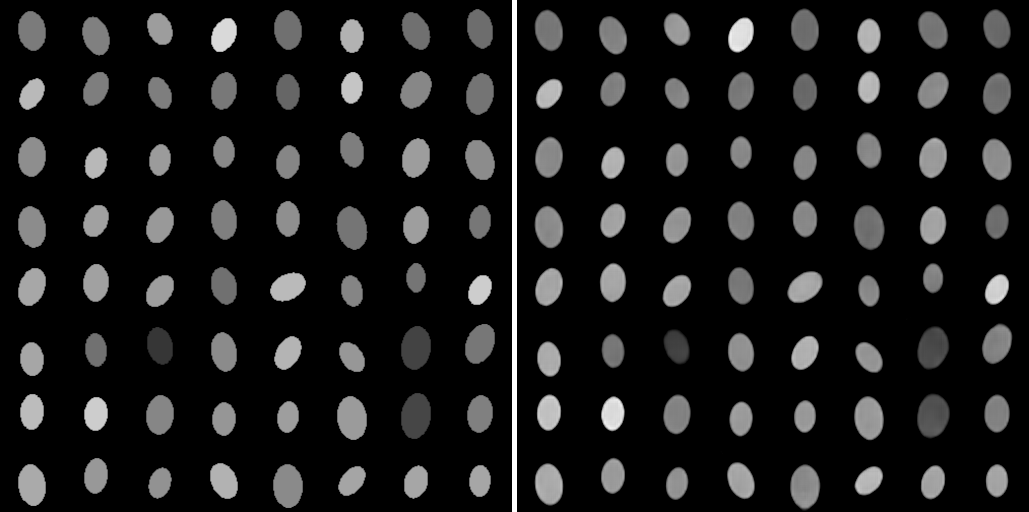

In [7]:
# first check the reconstruction images.  left: input ;   right: reconstruction
image = Image.open('./log/pvae/epoch150/test-0.png')
display(image)

In [10]:

dataloaders = get_celeba_loaders(1, 1)
with torch.no_grad():
    model.train(False)
    print(model.pe.weight)
    #exit(0)
    z_list,num_list, pos_list, rot_list, zp_list, bri_list,logit_out_list = [],[],[],[],[],[],[]


    for data in dataloaders["test"]:
        x = data[0]
        x = x.to(device)
        num_t = data[1].to(device)
        rot_t = data[2].to(device)
        pos_t = data[3].to(device)
        bri_t = data[4].to(device)
        rec_x, _, _, latent_z , zp= model(x)
        z_list.append(latent_z.unsqueeze(1))
        zp_list.append(zp.unsqueeze(1))
        bri_list.append(bri_t.unsqueeze(0))
        num_list.append(num_t.unsqueeze(0))
        rot_list.append(rot_t.unsqueeze(0))
        pos_list.append(pos_t.unsqueeze(0))

    z_list_tensor = torch.cat(z_list).squeeze(1)
    zp_list_tensor = torch.cat(zp_list).squeeze(1)
    zp_list_tensor = zp_list_tensor.squeeze(1)

    num_list_tensor = torch.cat(num_list).squeeze(1)
    bri_list_tensor = torch.cat(bri_list).squeeze(1)
    pos_list_tensor = torch.cat(pos_list).squeeze(1)
    rot_list_tensor = torch.cat(rot_list).squeeze(1)
    #exit(0)
    z_mean = torch.mean(z_list_tensor,dim=0)
    zp_mean = torch.mean(zp_list_tensor,dim=0)
    zp_std = torch.std(zp_list_tensor, dim=0)
    z_project_max,_ = torch.max(zp_list_tensor,dim=0)
    z_project_min,_ = torch.min(zp_list_tensor,dim=0)
    print('mean-3*SD, mean+3*SD:',model_lr((zp_mean-3*zp_std).unsqueeze(0)).item(), model_lr((zp_mean+3*zp_std).unsqueeze(0)).item())
    rec_tensors = torch.zeros((11,3, 64, 64))
    z_mean = z_mean.unsqueeze(0)


    flag_sampling = 1
    par_amp = 0.03
    loop_count = 0
    while flag_sampling and loop_count < 10000:      # control the sampling range to be mean+-3*SD
        loop_count = loop_count + 1
        middle_left = z_mean + par_amp*(0-5) * model.pe.weight  
        middle_right = z_mean + par_amp*(10-5) * model.pe.weight  
        middle_project_left = model.pe(middle_left)
        middle_project_right = model.pe(middle_right)
        #print(middle_project_right)
        tmp_max = torch.maximum(middle_project_left, middle_project_right)
        if torch.abs(tmp_max - (zp_mean+3*zp_std)) < 0.01:
            break
        if tmp_max - (zp_mean+3*zp_std) > 0:
            par_amp = par_amp - 0.001 
        else:
            par_amp = par_amp + 0.001

    
    points_list = []  # now start the sampling along vector p*
    for i in range(11): 
        middle = z_mean + (i-5) * model.pe.weight*par_amp 
        middle_project = model.pe(middle)
        logit_out = model_lr(middle_project)
        points_list.append(middle)
        print('brightness frame:',i+1, logit_out.item())
        rec_tensors[i] = model.decode(middle)
        rec_tensors[rec_tensors<0]=0
        rec_tensors[rec_tensors>1]=1
        imsave_inp(rec_tensors, os.path.join(logdir, f"{'frame'}-{i+1}.png"))



/home/lau/codes/env/lib/python3.6/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


Parameter containing:
tensor([[ 9.4433e-01, -5.1398e-03,  3.8334e-03, -8.8045e-04,  3.8666e-03,
          2.0657e-02, -2.4623e-01, -1.3721e-02]], device='cuda:1',
       requires_grad=True)
mean-3*SD, mean+3*SD: 0.3019355237483978 0.8535916805267334
brightness frame: 1 0.3028300702571869
brightness frame: 2 0.35781675577163696
brightness frame: 3 0.4128034710884094
brightness frame: 4 0.4677901864051819
brightness frame: 5 0.5227769017219543
brightness frame: 6 0.5777636170387268
brightness frame: 7 0.6327503323554993
brightness frame: 8 0.6877370476722717
brightness frame: 9 0.7427237629890442
brightness frame: 10 0.7977104783058167
brightness frame: 11 0.8526971936225891


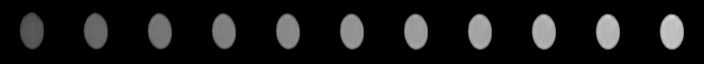

In [11]:
image = Image.open(os.path.join(logdir, f"{'frame'}-{11}.png")) # plot the 11 frames reconstructed images along vector p*
display(image) # Range: mean+- 3*SD

In [29]:
input_t_list = [1.0, 0.92, 0.84, 0.76, 0.68, 0.6, 0.52, 0.44, 0.36, 0.28, 0.2] #customized input 11 values of t
input_t_list_tensor = torch.from_numpy(np.array(input_t_list)).to(device) #
value_ki_list = []
rec_tensors = torch.zeros((11,1, 64, 64))
d_mean=[]
with torch.no_grad():
    model.train(False)
        #print(model.pe.weight)
        #exit(0)
    z_list,num_list, pos_list, rot_list, zp_list, bri_list,logit_out_list = [],[],[],[],[],[],[]

    for data in dataloaders["test"]:
        x = data[0]
        x = x.to(device)
        rec_x, _, _, latent_z , zp= model(x)
        z_list.append(latent_z.unsqueeze(1))
        z_list_tensor = torch.cat(z_list).squeeze(1)

    z_mean = torch.mean(z_list_tensor,dim=0)
    d_mean_tensor = z_mean.unsqueeze(0)    
for i in range(11):
    input_t = input_t_list[i]
    with torch.no_grad():


        flag_sampling = 1
        value_ki = 0.03
        loop_count = 0
        while flag_sampling and loop_count < 10000:      # loop while err < 0.001, within 10000 iterations
            loop_count = loop_count + 1
            sampled_point = d_mean_tensor + value_ki * model.pe.weight # model.pe.weight is the vector p in manuscript 
            sampled_zp = model.pe(sampled_point)
            predicted_t = model_lr(sampled_zp)
            #print(middle_project_right)
            if torch.abs(input_t-predicted_t) < 0.001:
                break
            if corr_loss_bri < 0:
                if input_t-predicted_t > 0:  # if corr(zp, t)<0, flip this to: input_t-predicted_t > 0 
                    value_ki = value_ki - 0.001 
                else:
                    value_ki = value_ki + 0.001
            else:
                if input_t-predicted_t < 0:  # if corr(zp, t)<0, flip this to: input_t-predicted_t > 0 
                    value_ki = value_ki - 0.001 
                else:
                    value_ki = value_ki + 0.001

        value_ki_list = np.append(value_ki_list,value_ki)

        sampled_point = d_mean_tensor +  value_ki* model.pe.weight 
        sampled_zp = model.pe(sampled_point)
        predicted_t = model_lr(sampled_zp)
        print('The predicted brightness of frame',i+1, predicted_t.item())
        rec_tensors[i] = model.decode(sampled_point)
        rec_tensors[rec_tensors<0]=0
        rec_tensors[rec_tensors>1]=1
        imsave_inp(rec_tensors, os.path.join(logdir, f"{'frame'}-{i+1}.png"))


 


The predicted brightness of frame 1 0.9990249276161194
The predicted brightness of frame 2 0.919083297252655
The predicted brightness of frame 3 0.8390556573867798
The predicted brightness of frame 4 0.7590280771255493
The predicted brightness of frame 5 0.6790004372596741
The predicted brightness of frame 6 0.5990588665008545
The predicted brightness of frame 7 0.5209243893623352
The predicted brightness of frame 8 0.4409828186035156
The predicted brightness of frame 9 0.36095523834228516
The predicted brightness of frame 10 0.2809275686740875
The predicted brightness of frame 11 0.20098599791526794


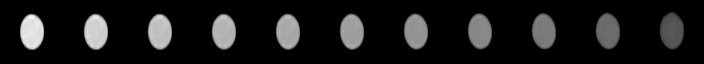

In [30]:
image = Image.open(os.path.join(logdir, f"{'frame'}-{11}.png"))
display(image)
# fix range customized by user [1.0, 0.92, 0.84, 0.76, 0.68, 0.6, 0.52, 0.44, 0.36, 0.28, 0.2]